In [3]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional
from langchain.schema import HumanMessage
import os


In [ ]:

llm = ChatNVIDIA(
    model="meta/llama3-70b-instruct",
    nvidia_api_key="NVIDIA_API_KEY",
    temperature=0.3
)

embedding = NVIDIAEmbeddings(
    model="nvidia/nv-embedqa-e5-v5",
    model_type="passage",
    nvidia_api_key="NVIDIA_API_KEY"
)

In [5]:
pdf_path = "C:\\Users\\Akshar Savaliya\\Downloads\\Agentic_NN.pdf"
if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"File not found: {pdf_path}")

pdf_loader = PyPDFLoader(pdf_path)
pages = pdf_loader.load()
print(f"PDF loaded successfully with {len(pages)} pages")

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
documents = text_splitter.split_documents(pages)

vectorstore = Chroma.from_documents(documents, embedding)
print("PDF embedded and stored in Chroma.")

PDF loaded successfully with 27 pages
PDF embedded and stored in Chroma.


In [6]:
class AgentState(TypedDict):
    input: str
    vector_data: Optional[str]
    rewritten_query: Optional[str]
    feedback: Optional[str]
    final_output: Optional[str]

def agent_node(state: AgentState) -> AgentState:
    print("Agent: Starting with input...")
    return state

def retrieval_node(state: AgentState) -> AgentState:
    print("Retriever: Searching ChromaDB...")
    docs = vectorstore.similarity_search(state["input"], k=3)
    content = "\n".join(doc.page_content for doc in docs)
    state["vector_data"] = content
    return state

def rewrite_node(state: AgentState) -> AgentState:
    print("Rewriter: Improving the query...")
    prompt = f"Rewrite the following query to improve document retrieval:\n\n{state['input']}"
    response = llm.invoke([HumanMessage(content=prompt)])
    state["rewritten_query"] = response.content
    state["input"] = response.content  
    return state

def generate_node(state: AgentState) -> AgentState:
    print(" Generator: Generating answer from retrieved context...")
    prompt = f"""Use the following context to answer the question.

    Context:
{state.get("vector_data", "")}

Question:
{state['input']}
"""
    response = llm.invoke([HumanMessage(content=prompt)])
    state["final_output"] = response.content
    return state

def feedback_node(state: AgentState) -> AgentState:
    print("Feedback: Critiquing the generated answer...")
    response = llm.invoke([
        HumanMessage(content=f"Provide feedback on this answer:\n\n{state['final_output']}")
    ])
    state["feedback"] = response.content
    return state


def check_vector_quality(state: AgentState) -> str:
    return "yes" if state.get("vector_data") else "no"


In [7]:
builder = StateGraph(AgentState)

builder.add_node("agent", agent_node)
builder.add_node("retrieval", retrieval_node)
builder.add_node("rewrite", rewrite_node)
builder.add_node("generate", generate_node)
builder.add_node("feedback_node", feedback_node)  

builder.add_edge("agent", "retrieval")

builder.add_conditional_edges("retrieval", check_vector_quality, {
    "yes": "generate",
    "no": "rewrite"
})

builder.add_edge("rewrite", "retrieval")
builder.add_edge("generate", "feedback_node")
builder.add_edge("feedback_node", END)

builder.set_entry_point("agent")
graph = builder.compile()

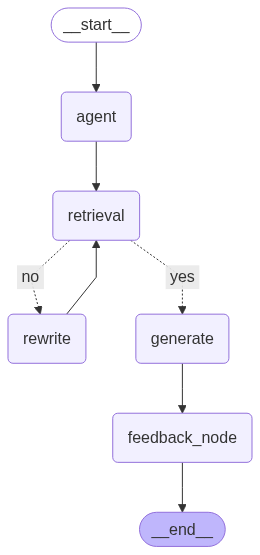

In [8]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:

if __name__ == "__main__":
    query = "What are the components of the Agentic Neural Network framework?"
    result = graph.invoke({"input": query})

    print("\nFinal Answer:\n", result["final_output"])
    print("\nFeedback:\n", result["feedback"])

Agent: Starting with input...
Retriever: Searching ChromaDB...
 Generator: Generating answer from retrieved context...
Feedback: Critiquing the generated answer...

Final Answer:
 Based on the provided context, the components of the Agentic Neural Network (ANN) framework are not explicitly listed. However, we can infer some components from the description:

1. **Dynamic selection mechanisms**: These are used to construct task-specific agent teams during the forward phase.
2. **Layer-wise optimization**: This is implied by the description of the framework adapting principles from classic neural networks, which use layer-wise optimization.
3. **Agent teams**: These are the multi-agent pipelines that are dynamically selected and refined layer by layer.
4. **Refinement mechanisms**: These are used to refine the agent teams if the performance does not meet expectations.

It is likely that the ANN framework also includes other components, such as learnable weights and numeric optimizers, sim